# Multi Class Logistic Regression with PyTorch

Softmax Regression (synonyms: Multinomial Logistic, Maximum Entropy Classifier, or just Multi-class Logistic Regression) is a generalization of logistic regression that we can use for multi-class classification (under the assumption that the classes are mutually exclusive). In contrast, we use the (standard) Logistic Regression model in binary classification tasks.

We will see now how to implement a bit more complex task with PyTorch. Which is, to predict the [*log-*]probability of a sample point (which could be a vector or a tensor) to belonging to a certain class, thus assigning the proper class label to each data point.

To to this we could use a simple linear layer as in the previous section, but a different loss, in particular we will use the cross entropy loss, which internally computes the softmax for the model's outputs (selecting the label with highest probability for each sample in a batch), and the NLLLoss, or Negative Log Likelihood Loss.

In information theory, the cross entropy between two probability distributions $p$ and $q$ over the same underlying set of events measures the average number of bits needed to identify an event drawn from the set, if a coding scheme is used that is optimized for an "unnatural" probability distribution $q$, rather than the "true" distribution $p$.

http://pytorch.org/docs/master/_modules/torch/nn/functional.html#cross_entropy

https://en.wikipedia.org/wiki/Cross_entropy

Let's import our usual packages and add the magic function to see the plots in this notebook

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

To approach this task, we want to classify MINST images (hand written digits), which are 28x28 B/W images, which sees images having thus $28\times28=784$ values, so the input size for our starting layer will be 748, MNIST has 0-9 digits, so we will have 10 classes, the others are more free parameters and we can set them how we want, let's say that we want to train our model for 5 epochs making it see the data from 100 images at each step and applying the updates to the parameters with a learning rate of 0.001

In [ ]:
# Hyper Parameters
input_size = 784
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

We then use again the super convenient dataset classes from the **torchvision** package

# MNIST
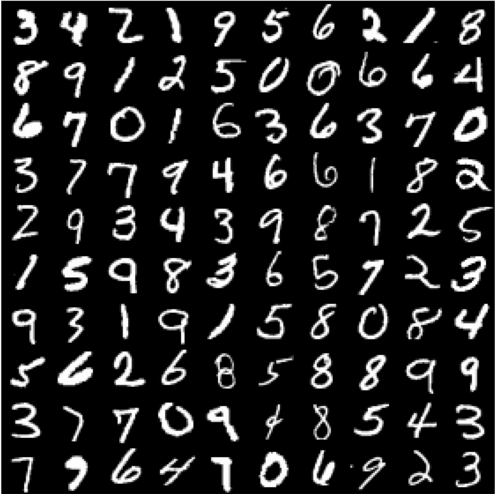

In [ ]:
# MNIST Dataset (Images and Labels)
# http://pytorch.org/docs/master/torchvision/datasets.html#torchvision.datasets.MNIST
# https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py
train_dataset = dsets.MNIST(root='../data/mnist', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='../data/mnist', 
                           train=False, 
                           transform=transforms.ToTensor())

# Dataset Loader (Input Pipline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

As seen previously, we can use pyplot to show us some of the images from the dataset, just be aware that pyplot normalize the values before showing them, if nothing else is specified. In this case the images are B/W and have 1 channel, so we could take the 0-th element of the tensor to actually take the image matrix and show it. 

In [ ]:
x, y = train_dataset[0]
print('Shape: {},'.format(x.shape), 'label: {}'.format(y))
plt.imshow(x.numpy()[0], cmap='gray')

We build our model as usual, the parametric class definition is the same as the one in the previous section (apart from the class name)

In [ ]:
# Model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, x):
        out = self.linear(x)
        return out

We than instantiate the model object, our loss and optimizer

In [ ]:
model = LogisticRegression(input_size, num_classes)
# same as 
# model = nn.Linear(input_size, num_classes)

# Loss and Optimizer
# Softmax is internally computed.
# Set parameters to be updated.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

We can now perform the training as before (as you can see, thanks to pytorch, we changed very few lines of code to literally change the task), given that the data points are a lot more than before, this training will take largely more time to complete

In [ ]:
# Training the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(images.view(-1, 28*28))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i + 1) % 300 == 0:
            print('Epoch: [%d/%d], Step: [%d/%d], Loss: %.4f' 
                  % (epoch + 1, num_epochs, i+1, len(
                      train_dataset) // batch_size, loss.item()))

After we trained our model, we can see its performances by performing a loop over all the test images, storing the maximum model's output for each image (label's log probability) and comparing it to our ground truth to get an accuracy metric. In this case we also show a confusion matrix for our model on this task.

A confusion matrix permits to visualize the performances of a model on a classification task, having the ground truths on its rows and the model's prediction on its columns, the values in this matrix' diagonal diagonal represent the number of correctly predicted samples, while the values on the other cells represents how many samples belonging to a class`c` get predicted as of another class `d`.

https://en.wikipedia.org/wiki/Confusion_matrix

In [ ]:
# Test the Model
model.eval()
correct = 0
total = 0
preds_list = []
labels_list = []
for images, labels in test_loader:
    images = images.view(-1, 28*28)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    preds_list += [predicted.numpy()]
    labels_list += [labels.numpy()]
    correct += (predicted == labels).sum()
preds_ary = np.hstack(preds_list)
labels_ary = np.hstack(labels_list)
confmat = confusion_matrix(preds_ary, labels_ary)

so we can now show our confusion matrix and validation accuracy, and saving the model `state_dict` as before

In [ ]:
print('Accuracy of the model on the 10000 test images: %d %%' % (100 * correct / total))
plt.matshow(confmat)
# Save the Model
torch.save(model.state_dict(), 'model.pth')